<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance Course

**Module 3 &mdash; Portfolio**

[team@tpq.io](mailto:team@tpq.io) | [http://tpq.io](http://tpq.io)

The Python Quants GmbH

## Requirements

Make sure to have installed locally a **comprehensive Python installation** like the [Anaconda](http://continuum.io/downloads) Python distribution.

Alternatively, and more easily, register on the **[Quant Platform](http://pqp.io)** where you can execute this Jupyter Notebook file in the browser. After registration, you find all Jupyter Notebook files of this course in the folder `pffcourse`.

## Necessary Imports

As usual, we need to **import certain modules/packages**.

In [1]:
import numpy as np  # array operations
import pandas as pd  # time series management
from pandas_datareader import data as web  # data retrieval
import matplotlib.pyplot as plt  # standard plotting library
import seaborn as sns; sns.set()  # nicer plotting style
# put all plots in the notebook itself
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Retrieving Stock Price Data

This module is about the **Markowitz Mean-Variance Portfolio Theoy (MVP)**. We need to retrieve some stock price data first to have something to work with. We build a portfolio of **tech companies**.

In [2]:
symbols = ['AAPL', 'MSFT', 'YHOO', 'AMZN', 'GOOG']  # our symbols
data = pd.DataFrame()  # empty DataFrame
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='yahoo')['Adj Close']

Let us inspect the **final five rows** of the `DataFrame` object.

In [3]:
data.tail()  # the final five rows

,AAPL,MSFT,YHOO,AMZN,GOOG
Date,,,,,
2016-04-05,109.809998,54.560001,36.410000,586.140015,737.799988
2016-04-06,110.959999,55.119999,36.660000,602.080017,745.690002
2016-04-07,108.540001,54.459999,36.169998,591.429993,740.280029
2016-04-08,108.660004,54.419998,36.070000,594.599976,739.150024
2016-04-11,109.019997,54.310001,36.480000,595.929993,736.099976


A **graphical comparison** of the complete time series data might also be helpful. We **normalize** the starting values to 100.

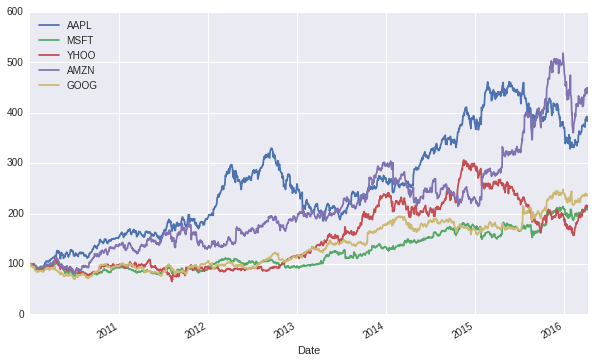

In [4]:
(data / data.ix[0] * 100).plot(figsize=(10, 6));

## Portfolio Returns

The first step in the calculation of a portfolio return is the calculation of the **annualized returns** of the different stocks based on the log returns for the respective time series.

In [5]:
# vectorized calculation of the log returns
log_rets = np.log(data / data.shift(1))

In [6]:
# annualized average log returns
rets = log_rets.mean() * 252
rets

AAPL    0.215439
MSFT    0.116316
YHOO    0.121076
AMZN    0.238582
GOOG    0.136621
dtype: float64

We now need to represent a **portfolio** by (normalized) weightings for the single stocks. Let us start with an equal weighting scheme.

In [7]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # equal weightings

In mathematical terms, the portfolio return is given as

\begin{eqnarray*}
\mu_p &=& \mathbf{E} \left( \sum_I w_i r_i \right) \\
        &=& \sum_I w_i \mathbf{E}\left( r_i \right) \\
        &=& \sum_I w_i \mu_i \\
        &=& w^T \mu
\end{eqnarray*}

where the $w_i$ are the weights for the single portfolio components and the $r_i$ are the respective returns.

We get for our specific case the following result.

In [8]:
np.dot(weights, rets)  # portfolio return (equal weights)

0.16560660984452885

## Portfolio Variance

The calculation of the **portfolio variance** is a bit more involved. Let us start with the definition of the **covariance matrix** which is needed to this end.

\begin{eqnarray*}
\Sigma = \begin{bmatrix}
        \sigma_{1}^2 \ \sigma_{12} \ \dots \ \sigma_{1I} \\
        \sigma_{21} \ \sigma_{2}^2 \ \dots \ \sigma_{2I} \\
        \vdots \ \vdots \ \ddots \ \vdots \\
        \sigma_{I1} \ \sigma_{I2} \ \dots \ \sigma_{I}^2
    \end{bmatrix}
\end{eqnarray*}

Here, we have the variances of the single stocks on the diagonal and the covariances between two stocks in the other places.

In Python, this matrix is easily calculated.

In [9]:
log_rets.cov() * 252  # annualized covariance matrix

,AAPL,MSFT,YHOO,AMZN,GOOG
AAPL,0.071775,0.025080,0.025221,0.029428,0.028147
MSFT,0.025080,0.054980,0.027612,0.030923,0.027442
YHOO,0.025221,0.027612,0.096180,0.041512,0.033763
AMZN,0.029428,0.030923,0.041512,0.109990,0.043396
GOOG,0.028147,0.027442,0.033763,0.043396,0.065012


Being equipped with the covariance matrix, the **portfolio variance** is defined as follows.

\begin{eqnarray*}
\sigma_p^2 &=& \mathbf{E}\left( (r - \mu)^2 \right) \\
        &=& \sum_{i \in I}\sum_{j \in I} w_i w_j \sigma_{ij} \\
        &=& w^T \Sigma w
\end{eqnarray*}

In Python, using NumPy, this is again a straightforward calculation.

In [10]:
# portfolio variance
pvar = np.dot(weights.T, np.dot(log_rets.cov() * 252, weights))
pvar

0.0409194124173477

The **portfolio volatility** then is

In [11]:
pvol = pvar ** 0.5
pvol

0.20228547258107216

## Random Portfolio Compositions

Next, let us generate a **random portfolio composition** and calculate the resulting portfolio return and variance.

In [12]:
weights = np.random.random(5)  # random numbers
weights /= np.sum(weights)  # normalization to 1

In [13]:
weights  # random portfolio composition

array([ 0.31286894,  0.0045248 ,  0.19205985,  0.16252221,  0.3280242 ])

In [14]:
np.dot(weights, rets)  # portfolio return (random weights)

0.17477401646938717

In [15]:
# portfolio variance (random weights)
np.dot(weights.T, np.dot(log_rets.cov() * 252, weights))

0.043995007323970395

We are now going to implement a **Monte Carlo simulation** for the portfolio weights and collect the resulting portfolio returns and volatilities.

In [16]:
%%time
prets = []
pvols = []
for p in xrange(5000):
    weights = np.random.random(5)
    weights /= np.sum(weights)
    prets.append(np.sum(log_rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(log_rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)
portfolio = pd.DataFrame({'return': prets, 'volatility': pvols})

CPU times: user 4 s, sys: 1 ms, total: 4 s
Wall time: 4 s


The collected results allow for an **insightful visualization**. We can easily spot the area of the **minimum variance portfolio** and also see the **efficient frontier** quite well.

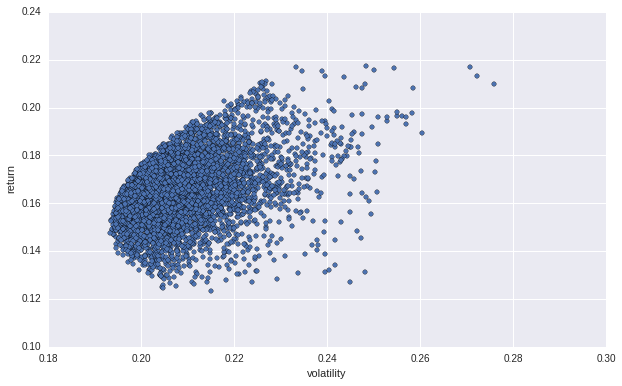

In [17]:
portfolio.plot(x='volatility', y='return', kind='scatter', figsize=(10, 6));

## Closing Remarks

This finishes the third module of the Python for Finance email course. In this module, you have learned:

* how to collect stock price data for multiple symbols
* how to calculate the return of a portfolio of multiple assets
* how to calculate the portfolio variance by the use of the covariance matrix
* how to simulate random portfolio compositions to visualize possible risk-return combinations

The portfolio theory presented in this module dates back to 1952 and is still a cornerstone today in (quantitative) finance.

## Exercises

In order to master the material of this module, do the following:

* replace the symbols used by other symbols and/or add more symbols
* work with different time horizons for the input data
* write Python code to find the minimum variance portfolio
* write Python code to find the portfolio compositions that make up the efficient frontier
* write Python code to determine the capital market line given a risk-free asset

## References

a

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>

**Listed Volatility and Variance Derivatives** |
<a href="http://lvvd.tpq.io" target="_blank">Listed VV Derivatives @ Wiley Finance</a>